# Dataset Distillation for Cat and Dog Image Classification - Further Investigation of Grid Clustering

## from "Ministry of Learning From Data Engineers"


#### Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

2024-06-09 09:37:36.233372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-06-09 09:37:36.233479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-06-09 09:37:36.341974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

In [2]:
# Define data directories for cats and dogs
cat_dir = "/kaggle/input/petimagescat-and-dog/PetImages/Cat"
dog_dir = "/kaggle/input/petimagescat-and-dog/PetImages/Dog"

# Define image size
img_size = 150

import time

def load_data(data_dir, label, count=7500, img_size=150):
    images = []
    labels = []

    i = 0
    
    for img_file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_file)
        try:
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            # Normalize pixel values
            img = img.astype(np.float32) / 255.0
            images.append(img)
            labels.append(label)
            i += 1
            if i % 1000 == 0:
                print(f"Loaded {i} images")
            
            # Check runtime
            if i >= count:
                break
             
        except Exception as e:
            continue
            
    return np.array(images), np.array(labels)


In [3]:
# Load and preprocess data for cats and dogs
print("Loading cat data...")
X_cat, y_cat = load_data(cat_dir, label=0)  # Cat label: 0
print("\nLoading dog data...")
X_dog, y_dog = load_data(dog_dir, label=1)  # Dog label: 1

# Concatenate cat and dog data
X = np.concatenate((X_cat, X_dog), axis=0)
y = np.concatenate((y_cat, y_dog), axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Loading cat data...


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


Loaded 1000 images


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


Loaded 2000 images

Loaded 3000 images

Loaded 4000 images

Loaded 5000 images


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


Loaded 6000 images


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


Loaded 7000 images



Loading dog data...

Loaded 1000 images


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Loaded 2000 images


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Loaded 3000 images


Loaded 4000 images

Loaded 5000 images

Loaded 6000 images


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Loaded 7000 images


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9

Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


X_train shape: (13500, 150, 150, 3)

y_train shape: (13500,)


## Base Model

In [4]:
class CNNModel:
    def __init__(self, img_size):
        self.img_size = img_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Conv2D(64, (3, 3), padding='same', input_shape=(self.img_size, self.img_size, 3)),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            MaxPooling2D((2, 2)),

            Flatten(),

            Dense(512),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            Dense(1, activation='sigmoid')  # Binary classification output
        ])
        return model

    
    def compile(self):
        self.model.compile(optimizer=Adam(),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    
    def summary(self):
        self.model.summary()
    
    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=20):
        self.history = self.model.fit(X_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      validation_data=(X_val, y_val))
    
    def evaluate(self, X_test, y_test):
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', test_acc)
        return test_loss, test_acc

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,467,457 (5.60 MB)

 Trainable params: 1,464,641 (5.59 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/20

  2/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.5156 - loss: 0.7852   


I0000 00:00:1717926091.051650     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6126 - loss: 0.7283

W0000 00:00:1717926131.681041     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


422/422 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.6127 - loss: 0.7282 - val_accuracy: 0.6273 - val_loss: 0.6450

Epoch 2/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.7574 - loss: 0.4978 - val_accuracy: 0.6267 - val_loss: 0.8665

Epoch 3/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8256 - loss: 0.3870 - val_accuracy: 0.8493 - val_loss: 0.3544

Epoch 4/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.8870 - loss: 0.2648 - val_accuracy: 0.8187 - val_loss: 0.4547

Epoch 5/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9155 - loss: 0.2032 - val_accuracy: 0.7307 - val_loss: 0.8047

Epoch 6/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9295 - loss: 0.1656 - val_accuracy: 0.8507 - val_loss: 0.3729

Epoch 7/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9484 - loss: 0.1281 - val_accuracy: 0.8873 - val_loss: 0.2745

Epoch 8/20

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9625 - loss: 0.099

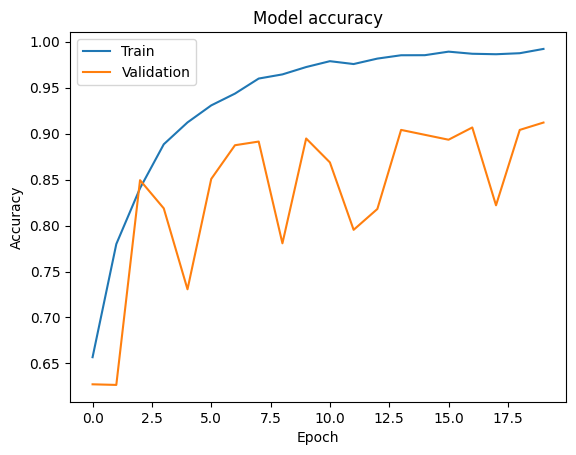

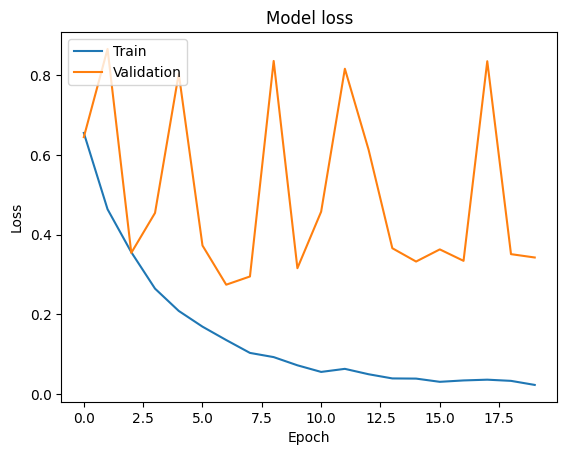

In [5]:
cnn_base = CNNModel(img_size=150)
cnn_base.compile()
cnn_base.summary()
plot_model(cnn_base.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
cnn_base.train(X_train, y_train, X_test, y_test, batch_size=32, epochs=20)

cnn_base_loss, cnn_base_acc = cnn_base.evaluate(X_test, y_test)

# Plot training and validation accuracy
plt.plot(cnn_base.history.history['accuracy'])
plt.plot(cnn_base.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(cnn_base.history.history['loss'])
plt.plot(cnn_base.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save model
cnn_base.model.save('cnn_base.h5')

## Clustering Distillation

In [11]:
class ImageClusterSampler:
    def __init__(self, X, y, n_clusters=2):
        self.X = X
        self.y = y
        self.n_clusters = n_clusters
        self.cluster_labels = None
        self.X_pca = None
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.pca = PCA(n_components=2, random_state=42)
    
    def cluster_images(self):
        self.kmeans.fit(self.X.reshape(self.X.shape[0], -1))
        self.cluster_labels = self.kmeans.labels_
        self.X_pca = self.pca.fit_transform(self.X.reshape(self.X.shape[0], -1))

    def plot_clusters(self):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')
        plt.title('Clustering of Cats and Dogs')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()

    def select_diverse_samples(self, cluster_indices, n_samples):


        if len(cluster_indices) <= n_samples:
            return cluster_indices
        
        selected_indices = []
        grid_size = int(np.ceil(np.sqrt(n_samples)))
        x_min, x_max = np.min(self.X_pca[:, 0]), np.max(self.X_pca[:, 0])
        y_min, y_max = np.min(self.X_pca[:, 1]), np.max(self.X_pca[:, 1])
        
        x_grid = np.linspace(x_min, x_max, grid_size + 1)
        y_grid = np.linspace(y_min, y_max, grid_size + 1)
        
        # plot also all the grids for each iteration on the same graph
        for i in range(grid_size):
            for j in range(grid_size):
                x_start, x_end = x_grid[i], x_grid[i + 1]
                y_start, y_end = y_grid[j], y_grid[j + 1]


                
                grid_indices = [
                    idx for idx in cluster_indices 
                    if x_start <= self.X_pca[idx, 0] < x_end and y_start <= self.X_pca[idx, 1] < y_end
                ]
                
                if grid_indices:
                    selected_indices.append(np.random.choice(grid_indices))

                
        
        while len(selected_indices) < n_samples:
            selected_indices.append(np.random.choice(cluster_indices))
        
        return selected_indices[:n_samples]

    def get_selected_samples(self, n_samples):
        selected_samples = []
        for label in range(2):
            label_indices = np.where(self.y == label)[0]
            label_cluster_labels = self.cluster_labels[label_indices]
            unique_clusters = np.unique(label_cluster_labels)
            
            for cluster_id in unique_clusters:
                cluster_indices = label_indices[label_cluster_labels == cluster_id]
                selected_indices = self.select_diverse_samples(cluster_indices, n_samples)
                selected_samples.extend(selected_indices)
        return selected_samples
    
    def plot_selected_samples_on_clusters(self, selected_samples):
        plt.figure(figsize=(10, 6))
        for i in range(self.n_clusters):
            cluster_data = self.X_pca[self.cluster_labels == i]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.5)
        
        selected_data = self.X_pca[selected_samples]
        plt.scatter(selected_data[:, 0], selected_data[:, 1], color='red', label='Selected Samples', edgecolor='k')
        
        plt.title('Clustering of Cats and Dogs with Selected Samples')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()




### 10%

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

  warnings.warn(


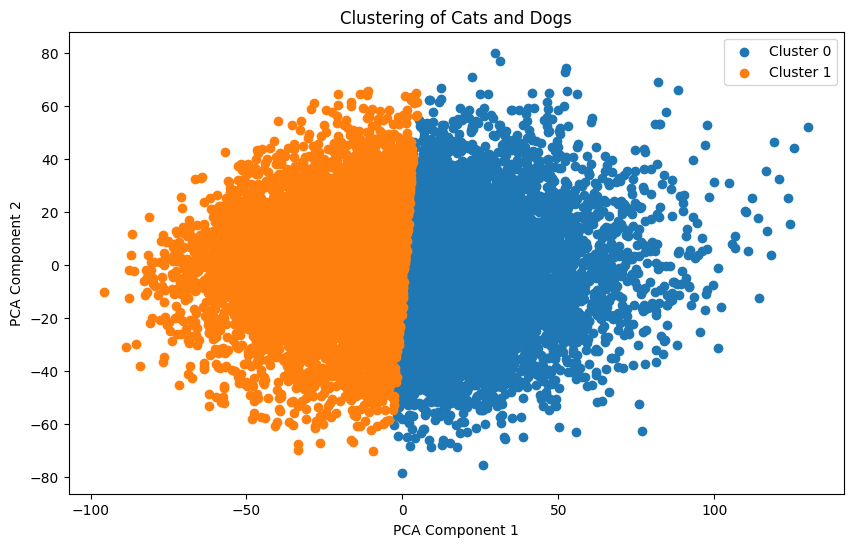

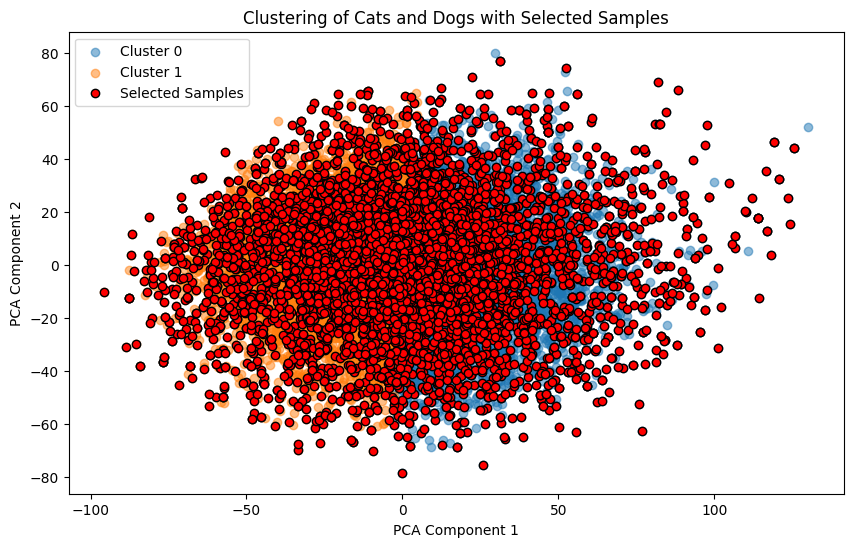

In [12]:
# Create image cluster sampler
sampler = ImageClusterSampler(X, y, n_clusters=2)
sampler.cluster_images()
sampler.plot_clusters()
selected_samples_1350 = sampler.get_selected_samples(1350)
sampler.plot_selected_samples_on_clusters(selected_samples_1350)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(


Epoch 1/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.5784 - loss: 0.7678 - val_accuracy: 0.4960 - val_loss: 0.7054

Epoch 2/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.6674 - loss: 0.6203 - val_accuracy: 0.5880 - val_loss: 0.6740

Epoch 3/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.7417 - loss: 0.5295 - val_accuracy: 0.7120 - val_loss: 0.5628

Epoch 4/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.8018 - loss: 0.4326 - val_accuracy: 0.8053 - val_loss: 0.4417

Epoch 5/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8456 - loss: 0.3450 - val_accuracy: 0.7613 - val_loss: 0.5497

Epoch 6/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8698 - loss: 0.3020 - val_accuracy: 0.7347 - val_loss: 0.7824

Epoch 7/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9165 - loss: 0.2166 - val_accuracy: 0.7993 - val_loss: 0.5313

Epoch 8/20

169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9359 -

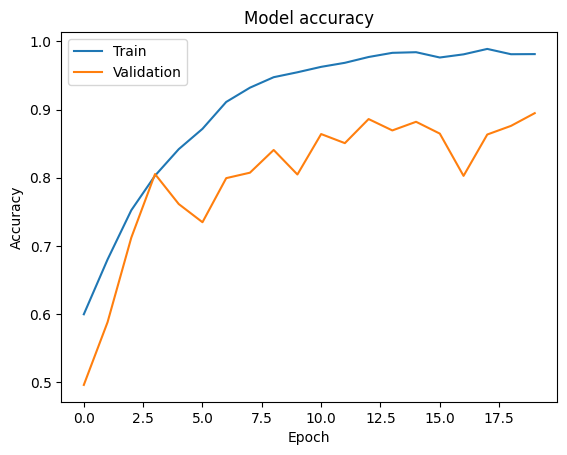

Test accuracy: 0.8946666717529297

Test loss: 0.4023839235305786


In [13]:
X_selected = X[selected_samples_1350]
y_selected = y[selected_samples_1350]

cnn_base_clustering_2 = CNNModel(img_size=150)
cnn_base_clustering_2.compile()
cnn_base_clustering_2.train(X_selected, y_selected, X_test, y_test, batch_size=32, epochs=20)
cnn_base_clustering_2_test_loss, cnn_base_clustering_2_test_acc = cnn_base_clustering_2.evaluate(X_test, y_test)

# Save model
cnn_base_clustering_2.model.save('cnn_base_clustering.h5')

# Plot training and validation accuracy
plt.plot(cnn_base_clustering_2.history.history['accuracy'])
plt.plot(cnn_base_clustering_2.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print('Test accuracy:', cnn_base_clustering_2_test_acc)
print('Test loss:', cnn_base_clustering_2_test_loss)